### **Proyecto K-Nearest Neighbors  - Luis Alpizar**
- **Source**: 4Geeks
- **URLs**: https://raw.githubusercontent.com/4GeeksAcademy/k-nearest-neighbors-project-tutorial/main/tmdb_5000_movies.csv
<br>        https://raw.githubusercontent.com/4GeeksAcademy/k-nearest-neighbors-project-tutorial/main/tmdb_5000_credits.csv


### Paso 0: Importar Librerias

In [ ]:
# Importacion de Librerias
# Registros y serialización
import logging
import pickle

# Análisis de datos, base de datos
import pandas as pd
import numpy as np
import sqlite3
import json


# Visualización de datos
import matplotlib.pyplot as plt
import seaborn as sns

# Modelado y evaluación
from sklearn.model_selection import (
    train_test_split,
    cross_validate,
    cross_val_predict,
    GridSearchCV
)

# Pipelines
from sklearn.pipeline import Pipeline

# Preprocesamiento
from sklearn.preprocessing import (
    PowerTransformer,
    LabelEncoder,
    MinMaxScaler
)

# KNN
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import NearestNeighbors

# Métricas
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    r2_score,
    accuracy_score,
    f1_score,
    classification_report,
    ConfusionMatrixDisplay,

)

# Inspección
from sklearn.inspection import permutation_importance
from sklearn.utils import resample

# Configuración del registro
logger = logging.getLogger()
logger.setLevel(logging.ERROR)


### Paso 1: Carga del dataset

In [ ]:
url_movies = 'https://raw.githubusercontent.com/4GeeksAcademy/k-nearest-neighbors-project-tutorial/main/tmdb_5000_movies.csv'
url_credits = 'https://raw.githubusercontent.com/4GeeksAcademy/k-nearest-neighbors-project-tutorial/main/tmdb_5000_credits.csv'

raw_movies = pd.read_csv(url_movies)
raw_credits = pd.read_csv(url_credits)

### Paso 2: Data preprocessing
<br> Creacion de la base de datos para almacenar ambos datasets y convertirlos en uno solo

In [ ]:
con_db = sqlite3.connect("../data/movies_database.db")

raw_movies.to_sql("movies_table", con_db, if_exists = "replace", index = False)
raw_credits.to_sql("credits_table", con_db, if_exists = "replace", index = False)

4803

In [ ]:
#Devuelve todas las filas de movies_table y credits_table donde los valores de la columna title coinciden en ambas tablas.
consulta = """
    SELECT *
    FROM movies_table
    INNER JOIN credits_table
    ON movies_table.title = credits_table.title;
"""
df_raw = pd.read_sql_query(consulta, con_db)
con_db.close()

In [ ]:
df_baking = df_raw.copy()
df_baking.columns = df_baking.columns.str.replace(' ', '_').str.replace('(', '').str.replace(')', '').str.lower()
df_baking.columns = df_baking.columns.str.lower()

df_baking = df_baking.T.drop_duplicates().T
#df_baking.sample(10, random_state=2025)

In [ ]:
#Limpieza de las columnas del dataset en formato JSON. Tomado de la solución del proyecto.
def load_json_safe(json_str, default_value=None):
    try:
        return json.loads(json_str)
    except (TypeError, json.JSONDecodeError):
        return default_value

df_baking["genres"] = df_baking["genres"].apply(lambda x: [item["name"] for item in json.loads(x)] if pd.notna(x) else None)
df_baking["keywords"] = df_baking["keywords"].apply(lambda x: [item["name"] for item in json.loads(x)] if pd.notna(x) else None)

df_baking["cast"] = df_baking["cast"].apply(lambda x: [item["name"] for item in json.loads(x)][:3] if pd.notna(x) else None)

df_baking["crew"] = df_baking["crew"].apply(lambda x: " ".join([crew_member['name'] for crew_member in load_json_safe(x) if crew_member['job'] == 'Director']))

df_baking["overview"] = df_baking["overview"].apply(lambda x: [x])

df_baking.head()

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,...,runtime,spoken_languages,status,tagline,title,vote_average,vote_count,movie_id,cast,crew
0,237000000,"[Action, Adventure, Fantasy, Science Fiction]",http://www.avatarmovie.com/,19995,"[culture clash, future, space war, space colon...",en,Avatar,"[In the 22nd century, a paraplegic Marine is d...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...",...,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800,19995,"[Sam Worthington, Zoe Saldana, Sigourney Weaver]",James Cameron
1,300000000,"[Adventure, Fantasy, Action]",http://disney.go.com/disneypictures/pirates/,285,"[ocean, drug abuse, exotic island, east india ...",en,Pirates of the Caribbean: At World's End,"[Captain Barbossa, long believed to be dead, h...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...",...,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500,285,"[Johnny Depp, Orlando Bloom, Keira Knightley]",Gore Verbinski
2,245000000,"[Action, Adventure, Crime]",http://www.sonypictures.com/movies/spectre/,206647,"[spy, based on novel, secret agent, sequel, mi...",en,Spectre,[A cryptic message from Bond’s past sends him ...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...",...,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466,206647,"[Daniel Craig, Christoph Waltz, Léa Seydoux]",Sam Mendes
3,250000000,"[Action, Crime, Drama, Thriller]",http://www.thedarkknightrises.com/,49026,"[dc comics, crime fighter, terrorist, secret i...",en,The Dark Knight Rises,[Following the death of District Attorney Harv...,112.31295,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...",...,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106,49026,"[Christian Bale, Michael Caine, Gary Oldman]",Christopher Nolan
4,260000000,"[Action, Adventure, Science Fiction]",http://movies.disney.com/john-carter,49529,"[based on novel, mars, medallion, space travel...",en,John Carter,"[John Carter is a war-weary, former military c...",43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]",...,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124,49529,"[Taylor Kitsch, Lynn Collins, Samantha Morton]",Andrew Stanton


In [ ]:
#Tomamos las etiquetas relevantes y las ponemos en una sola columna "tags"
df_baking["overview"] = df_baking["overview"].apply(lambda x: [str(x)])
df_baking["genres"] = df_baking["genres"].apply(lambda x: [str(genre) for genre in x])
df_baking["keywords"] = df_baking["keywords"].apply(lambda x: [str(keyword) for keyword in x])
df_baking["cast"] = df_baking["cast"].apply(lambda x: [str(actor) for actor in x])
df_baking["crew"] = df_baking["crew"].apply(lambda x: [str(crew_member) for crew_member in x])

df_baking["tags"] = df_baking["overview"] + df_baking["genres"] + df_baking["keywords"] + df_baking["cast"] + df_baking["crew"]
df_baking["tags"] = df_baking["tags"].apply(lambda x: ",".join(x).replace(",", " "))

df_baking.drop(columns=["genres", "keywords", "cast", "crew", "overview"], inplace=True)

df_baking.iloc[0].tags

"['In the 22nd century  a paraplegic Marine is dispatched to the moon Pandora on a unique mission  but becomes torn between following orders and protecting an alien civilization.'] Action Adventure Fantasy Science Fiction culture clash future space war space colony society space travel futuristic romance space alien tribe alien planet cgi marine soldier battle love affair anti war power relations mind and soul 3d Sam Worthington Zoe Saldana Sigourney Weaver J a m e s   C a m e r o n"

In [ ]:
df=df_baking.copy()

In [ ]:
#Guardado del la base de datos y el archivo .csv
df.to_csv("../data/processed/clean_data.csv", index = False)

con_db = sqlite3.connect("../data/movies_database.db")

raw_movies.to_sql("clean_movies_data", con_db, if_exists = "replace", index = False)
con_db.close()

### Paso 3: Exploratory Data Analysis

In [ ]:
df_train, df_test = train_test_split(
    df, test_size=0.15,
    random_state=2025
)
df_train, df_val = train_test_split(
    df_train, test_size=0.15,
    random_state=2025
)
df_train.reset_index(drop=True, inplace=True)
df_val.reset_index(drop=True, inplace=True)
df_test.reset_index(drop=True, inplace=True)
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3473 entries, 0 to 3472
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   budget                3473 non-null   object
 1   homepage              1235 non-null   object
 2   id                    3473 non-null   object
 3   original_language     3473 non-null   object
 4   original_title        3473 non-null   object
 5   popularity            3473 non-null   object
 6   production_companies  3473 non-null   object
 7   production_countries  3473 non-null   object
 8   release_date          3472 non-null   object
 9   revenue               3473 non-null   object
 10  runtime               3472 non-null   object
 11  spoken_languages      3473 non-null   object
 12  status                3473 non-null   object
 13  tagline               2854 non-null   object
 14  title                 3473 non-null   object
 15  vote_average          3473 non-null   

In [ ]:
df_train.sample(10,random_state=2025)

,budget,homepage,id,original_language,original_title,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count,movie_id,tags
1216,0,None,318040,en,Bizarre,0.583446,"[{""name"": ""Eivissa Productions"", ""id"": 72942},...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2015-02-07,0,99.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,None,Bizarre,6.2,11,318040,['Maurice a reticent young homeless man some...
3015,0,None,281730,en,Fugly,0.371337,[],"[{""iso_3166_1"": ""IN"", ""name"": ""India""}]",2014-06-13,0,134.0,"[{""iso_639_1"": ""hi"", ""name"": ""\u0939\u093f\u09...",Released,None,Fugly,5.3,2,281730,"[""It is a story of 4 friends - Dev Gaurav Ad..."
2916,100000000,None,280,en,Terminator 2: Judgment Day,101.74155,"[{""name"": ""Lightstorm Entertainment"", ""id"": 57...","[{""iso_3166_1"": ""FR"", ""name"": ""France""}, {""iso...",1991-07-01,520000000,137.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,It's nothing personal.,Terminator 2: Judgment Day,7.7,4185,280,['Nearly 10 years have passed since Sarah Conn...
3153,33000000,http://marvel.com/movies/movie/5/the_punisher,7220,en,The Punisher,35.099611,"[{""name"": ""Lions Gate Films"", ""id"": 35}, {""nam...","[{""iso_3166_1"": ""DE"", ""name"": ""Germany""}, {""is...",2004-04-15,54700105,124.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"There is no justice, there is only revenge.",The Punisher,6.1,766,7220,"[""When undercover FBI agent Frank Castle's wif..."
1696,0,http://www.sonypictures.com/movies/superbabies...,31117,en,Superbabies: Baby Geniuses 2,5.886228,"[{""name"": ""Crystal Sky Worldwide"", ""id"": 4077}...","[{""iso_3166_1"": ""DE"", ""name"": ""Germany""}, {""is...",2004-08-27,9109322,88.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,Meet the new generation of superheroes.,Superbabies: Baby Geniuses 2,1.9,35,31117,"[""Following on from the plot of the last movie..."
881,3700000,None,35032,en,The Pirate,0.90522,"[{""name"": ""Metro-Goldwyn-Mayer (MGM)"", ""id"": 8...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",1948-06-11,2956000,102.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The great MGM musical romance,The Pirate,6.6,17,35032,['A girl is engaged to the local richman but ...
2899,5000000,http://www.stayinyourroom.com/,298312,en,The Visit,38.94708,"[{""name"": ""Blumhouse Productions"", ""id"": 3172}...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2015-09-10,98450062,94.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,No one loves you like your grandparents.,The Visit,6.0,1360,298312,"[""The terrifying story of a brother and sister..."
702,15000000,None,16769,en,Coal Miner's Daughter,3.826685,"[{""name"": ""Universal Pictures"", ""id"": 33}]","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",1980-03-07,67182787,125.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,She was married at 13. She had four kids by th...,Coal Miner's Daughter,7.2,67,16769,['Biography of Loretta Lynn a country and wes...
3130,9000000,None,327833,en,Skin Trade,6.677926,"[{""name"": ""SC Films International"", ""id"": 2061...","[{""iso_3166_1"": ""CA"", ""name"": ""Canada""}, {""iso...",2014-11-07,0,96.0,"[{""iso_639_1"": ""th"", ""name"": ""\u0e20\u0e32\u0e...",Released,Two Cops. One Mission. No Mercy.,Skin Trade,5.6,61,327833,['After his family is killed by a Serbian gang...
1329,0,None,43743,en,Fabled,0.003352,[],[],2002-01-01,0,84.0,[],Released,There once was a wolf named Lupold...,Fabled,0.0,0,43743,"[""Joseph just broke up with his girlfriend and..."


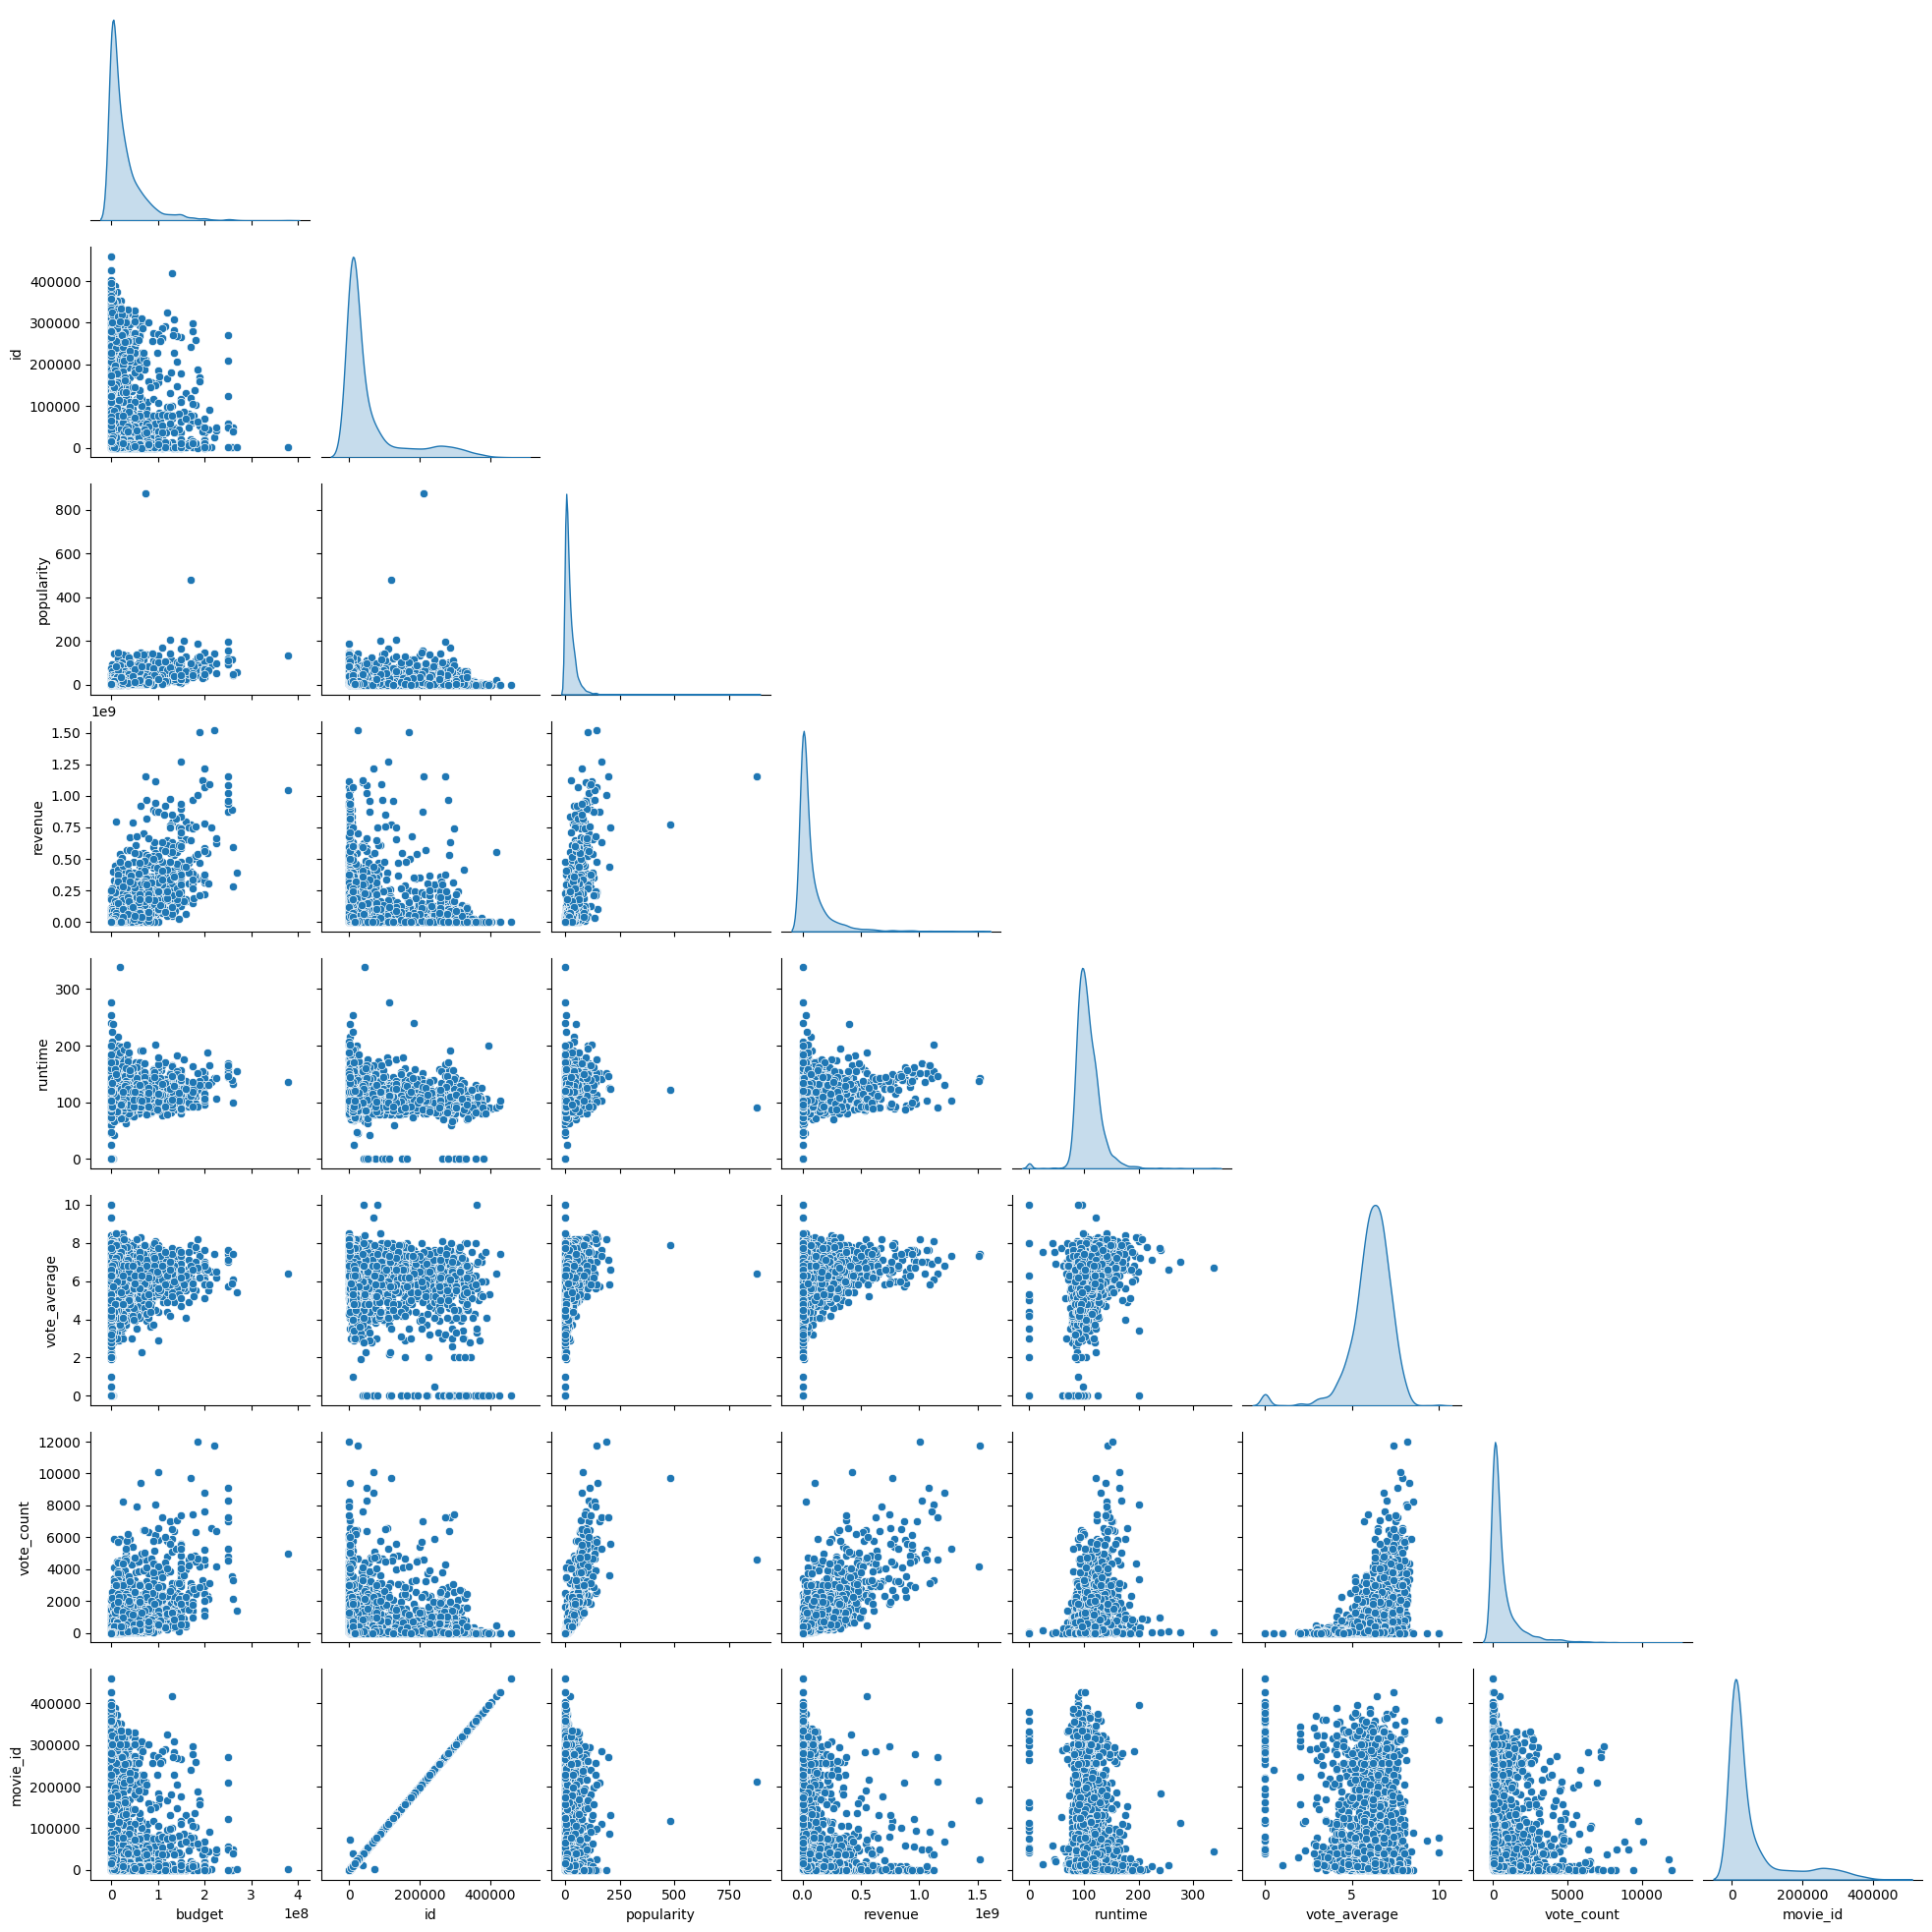

In [ ]:
#Analisis Bivariado
sns.pairplot(df_train, diag_kind='kde',corner=True)
plt.show()

### **4. Machine learning**
**Objective**: Create a model that learns from data to make predictions and generalize to unseen data, and thus perform tasks without explicit instructions

In [ ]:
X_train = df_train.drop(columns=['lc50'])
y_train = df_train['lc50']
X_val = df_val.drop(columns=['lc50'])
y_val = df_val['lc50']
X_test = df_test.drop(columns=['lc50'])
y_test = df_test['lc50']

In [ ]:
#Pipeline
knn_pipe = Pipeline([
    ('vectorizer', TfidfVectorizer()),  # Vectorización TF-IDF
    ('knn', NearestNeighbors(n_neighbors=6, algorithm='brute', metric='cosine'))  # Modelado KNN
])
knn_pipe.fit(df_baking["tags"])


Pipeline(steps=[('vectorizer', TfidfVectorizer()),
                ('knn',
                 NearestNeighbors(algorithm='brute', metric='cosine',
                                  n_neighbors=6))])

In [ ]:
# Función para obtener recomendaciones de películas
def recomendar_peliculas(movie_title):

    movie_index = df_baking[df_baking["title"] == movie_title].index[0] # Encuentra el índice de la película en el DataFrame

    tfidf_matrix = knn_pipe.named_steps['vectorizer'].transform(df_baking["tags"]) # Calcula la matriz TF-IDF para la columna 'tags'

    distances, indices = knn_pipe.named_steps['knn'].kneighbors(tfidf_matrix[movie_index]) # Encuentra los vecinos más cercanos utilizando el paso 'knn' del pipeline

    similar_movies = [(df_baking["title"][i], distances[0][j]) for j, i in enumerate(indices[0])] # Obtén las películas similares

    return similar_movies[1:]  # Excluye la película original

In [ ]:
recomendacion = recomendar_peliculas("Star Wars")
print("Películas que recomiendo en base a '{}':".format(input_movie))
for movie, distance in recomendacion:
    print(f"{movie}")

Películas que recomiendo en base a 'Star Wars':
The Empire Strikes Back
Return of the Jedi
Star Wars: Episode III - Revenge of the Sith
Star Wars: Episode II - Attack of the Clones
The Ice Pirates
